In [142]:
import warnings
warnings.filterwarnings("ignore")

# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import pair_confusion_matrix 
from sklearn.metrics import adjusted_rand_score



# 1. Load the data, the attributes are all qualitative and there is no label column, show the shape of the data and for each column show the frequencies of each distinct value (hint: you can use the numpy function unique(x, return_counts = True)

In [125]:
path = './exam_2021_02_17_data.csv'
sep = '\t'

df = pd.read_csv(path, sep=sep)

print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

freqs = {}
for c in df.columns :
    print("#"*40, f"For {c}", "#"*40)
    vals, n_occ = np.unique(df[c], return_counts=True)
    for i in range(len(vals)) :
        print(f"{vals[i]}:\t{(n_occ[i] / df.shape[0] * 100):.4f}%")

    # Not requested
    # freqs[c] = {
    #     'vals' : vals,
    #     'f' : n_occ / df.shape[0]
    # }



The dataset has 1000 rows and 3 columns
######################################## For F0 ########################################
a:	10.0000%
b:	10.0000%
c:	10.0000%
d:	10.0000%
e:	10.0000%
f:	10.0000%
g:	10.0000%
h:	10.0000%
i:	10.0000%
j:	10.0000%
######################################## For F1 ########################################
a:	10.0000%
b:	9.9000%
c:	10.0000%
d:	10.0000%
e:	10.1000%
f:	10.0000%
g:	10.0000%
h:	10.0000%
i:	10.0000%
j:	10.0000%
######################################## For F2 ########################################
a:	10.0000%
b:	9.9000%
c:	10.0000%
d:	10.0000%
e:	10.1000%
f:	10.0000%
g:	10.0000%
h:	10.0000%
i:	10.0000%
j:	10.0000%


# 2) Do the appropriate pre-processing in order to use the sklearn algorithms on this dataset; the values are qualitative and must be considered as nominal

In [126]:
# NON VA BENE !!! --> va bene solo se sono ordinali
# from sklearn.preprocessing import OrdinalEncoder
# oe = OrdinalEncoder()
# labels = df.columns
# df = pd.DataFrame(oe.fit_transform(df), columns=labels)

encoder = OneHotEncoder(sparse=False)
df_encoded = pd.DataFrame(encoder.fit_transform(df), columns=encoder.get_feature_names_out(df.columns))


In [127]:
df_encoded

,F0_a,F0_b,F0_c,F0_d,F0_e,F0_f,F0_g,F0_h,F0_i,F0_j,...,F2_a,F2_b,F2_c,F2_d,F2_e,F2_f,F2_g,F2_h,F2_i,F2_j
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
996,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 3. As an external background knowledge, we are told that for this dataset a requirement for a good clustering scheme is to have clusters with low deviation in sizes, e.g. a scheme with cluster sizes (330, 670) is less acceptable than one with (333, 333, 334). 

In order to obtain this, we want to compute, for each clustering scheme with n_clusters clusters and represented by the labels in y, a size deviation index with the formula 

`np.sqrt(np.unique(y, return_counts = True)[1].var())/n_clusters`

For varying number of clusters fit KMeans and compute the inertia, the silhouette index and the above‑mentioned size deviation index.

In [128]:
# Size deviation index
# size_dev_indx = np.sqrt(np.unique(y, return_counts = True)[1].var())/n_clusters

X = df_encoded # to make the procedure more readable

k_range = range(2,11)

random_state = 42
silhouette_scores = []
inertia_scores = []
deviation_scores = []

for k in k_range :
    km = KMeans(n_clusters=k, random_state=random_state)
    y_km = km.fit_predict(X)

    size_dev_indx = np.sqrt(np.unique(y_km, return_counts = True)[1].var())/k
    
    deviation_scores.append(size_dev_indx)
    silhouette_scores.append(silhouette_score(X,y_km))
    inertia_scores.append(km.inertia_)



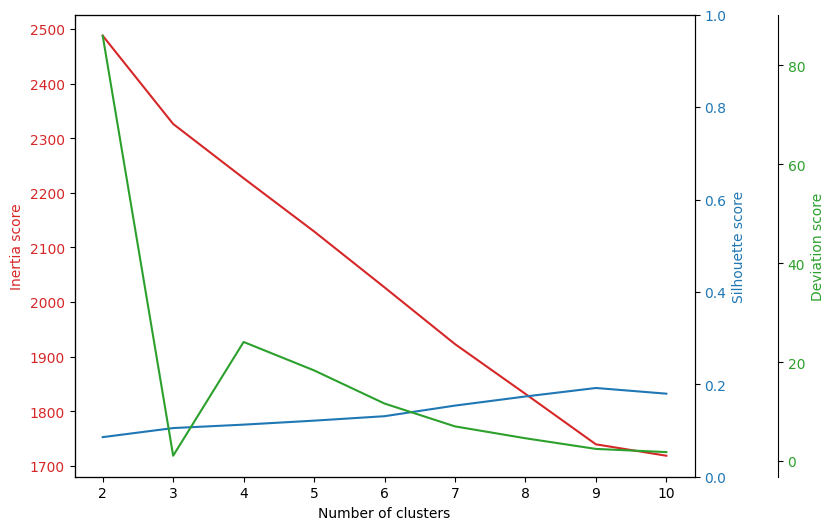

In [129]:
# fig, ax1 = plt.subplots()

# # Inertia
# color = 'tab:red'
# ax1.set_xlabel("Number of clusters")
# ax1.set_ylabel("Inertia score", color=color)
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.plot(k_range, inertia_scores, color=color)

# # Silhouette
# ax2 = ax1.twinx()
# color = 'tab:blue'
# ax2.set_ylabel("Silhouette score", color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.plot(k_range, silhouette_scores, color=color)
# ax2.set_ylim(0,1) 

# # Deviation
# ax3 = ax2.twinx()
# color = 'tab:green'
# ax3.set_ylabel("Deviation score", color=color)
# ax3.tick_params(axis='y', labelcolor=color)
# ax3.plot(k_range, deviation_scores, color=color)

# Creazione della figura con tre assi sovrapposti
fig, ax1 = plt.subplots(figsize=(8, 6))

# Inertia
color = 'tab:red'
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia score", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(k_range, inertia_scores, color=color)

# Crea un secondo asse Y a destra di ax1
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Silhouette score", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(k_range, silhouette_scores, color=color)
ax2.set_ylim(0,1)

# Crea un terzo asse Y a destra di ax1
ax3 = ax1.twinx()
color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Sposta la spina dorsale dell'asse a destra
ax3.set_ylabel("Deviation score", color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.plot(k_range, deviation_scores, color=color)

plt.show()

- As we can see the silhouette is always low (between 0 and 0.2) and so doesn't give much information (anyway the maximum value is in k=9).

- Looking at inertia, we can see it decreases at linear speed but we can notice 2 elbows: k=3 and k=9

- Considering deviation (which we are asked to minimize), we can notice that there are 2 minimum values: k=3 and k=9

With these consideration i think the best compromise as number of cluster could be k=3

## 5. Fit another clustering method of your choice, trying to reproduce the same number of clusters you have chosen in the previous step

In [141]:
from sklearn.model_selection import ParameterGrid

# All the possible combinations of paramters
params = list(ParameterGrid({
    'eps' : list(np.arange(1,30,1)),
    'min_samples' : list(np.arange(50,300,5))
}))

# Procedure
for i in range(len(params)) :
    # Use model with i-th parameters
    db = DBSCAN(**(params[i]))
    y_db = db.fit_predict(X)

    # Handle the noisy points
    cluster_labels_all = np.unique(y_db)
    n_cl = len(cluster_labels_all[cluster_labels_all != -1])
    if n_cl > 1 :
        # print(X.shape)
        # print(X)
        # print(y_db.shape)
        # print(y_db)
        X_cl = X.loc[y_db!=-1, :]
        y_db_cl = y_db[y_db!=-1]
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - y_db_cl.shape[0]/y_db.shape[0]) * 100
        s_deviation = np.sqrt(np.unique(y_db_cl, return_counts = True)[1].var())/n_cl

        print("{:11.2f}\t{:11}\t{:11}\t{:11.2f}\t{:11.2f}\t{:11.2f}"\
                  .format(db.eps, db.min_samples, n_cl, silhouette, uncl_p, s_deviation))

       2.00	        280	          2	       0.06	      38.30	      57.75


## 6. Compare the results of the two clustering showing the result of sklearn.metrics.cluster.pair_confusion_matrix and sklearn.metrics.adjusted_rand_score

In [145]:
# Collect the 2 results
y_km = KMeans(random_state=random_state, n_clusters=3).fit_predict(X)
y_db = DBSCAN(eps=2, min_samples=280).fit_predict(X)

display(pair_confusion_matrix(y_km, y_db))
adjusted_rand_score(y_km, y_db)

array([[439516, 227118],
       [196770, 135596]])

0.0657725507337665